## K2-24 Fitting & MCMC

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to:

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space
- plot the results


Perform some preliminary imports:

In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

In [2]:
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = 20.885258
    params['tc1'] = 2072.79438
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1.1
    params['per2'] = 42.363011
    params['tc2'] = 2082.62516
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1.1
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = -0.02
    mod.params['curv'] = 0.01
    return mod


Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in an csv file

In [4]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

### Fit the K2-24 RV data assuming:

1. circular orbits
2. fixed period, time of transit

Set initial guesses for the parameters

In [5]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 0.1
like.params['jit'] = 1.0

Choose which parameters to vary or fix

In [6]:
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False
like.vary['curv'] = True
print like

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
jit                               1       True
gamma                           0.1       True



Plot the initial model

/Users/bfulton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


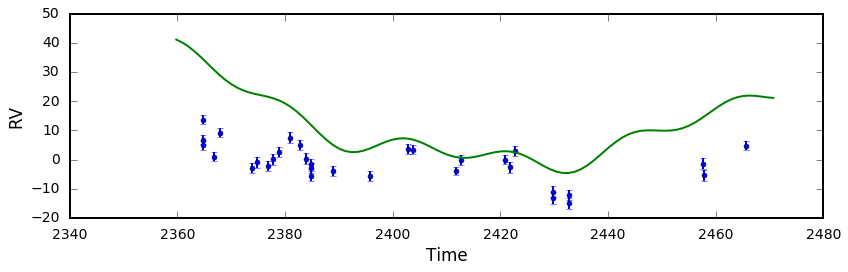

In [7]:
pl.figure()
plot_results(like)

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object and add some priors

In [ ]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

Maximize the likelihood and print the updated posterior object

In [ ]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post

That looks much better!

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.
In this example we will run 1000 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers. If the chains converge before they reach the maximum number of allowed steps it will automatically stop.

In [ ]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

Now lets make a corner plot to display the posterior distributions.

In [ ]:
radvel.plotting.corner_plot(post, df)

### Eccentric Fit

Allow ``secosw`` and ``sesinw`` parameters to vary

In [ ]:
like.vary.update(secosw1=True,
                 sesinw1=True,
                 secosw2=True,
                 sesinw2=True)

Add an ``EccentricityPrior`` to ensure that eccentricity stays below 1.0. In this example we will also add a Gaussian prior on the jitter (``jit``) parameter with a center at 2.0 m/s and a width of 0.1 m/s.

In [ ]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'jit', np.log(2), np.log(0.1))]

Optimize the parameters by maximizing the likelihood and plot the result

In [ ]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like)
print post

Run the MCMC again

In [ ]:
df = radvel.mcmc(post,threads=1,nwalkers=20,nrun=1000)

Convert into more physical parameters and make another corner plot

In [ ]:
df['k1'] = np.exp(df['logk1'])
df['k2'] = np.exp(df['logk2'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])


labels = 'k1 k2 jit e1 e2'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84]
    )

Plot the final solution

In [ ]:
radvel.plotting.rv_multipanel_plot(post)